![treliça](../assets/trelica_howe.png)

In [1]:
import os
import random
import numpy as np
import math as m
import matplotlib.pyplot as plt

from dataclasses import dataclass
from tabulate import tabulate
from enum import Enum
from time import sleep
from IPython.display import clear_output
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
# Funções de utilidade para calcular, ângulos, forças internas e deslocamento

def get_all_lengths_list(lengths: list[float]) -> list[float]:
    """
    Lengths: L1, L2, L3, L4, L6, L8, L10
    """
    L = lengths[:4]
    L.append(m.sqrt((lengths[0]**2 + lengths[4]**2)))                  # L5
    L.append(lengths[4])                                               # L6
    L.append(m.sqrt((lengths[1]**2 + lengths[4]**2)))                  # L7
    L.append(lengths[5])                                               # L8
    L.append(m.sqrt((lengths[2]**2 + lengths[6]**2)))                  # L9
    L.append(lengths[6])                                               # L10
    L.append(m.sqrt((lengths[3]**2 + lengths[6]**2)))                  # L11
    L.append(m.sqrt(abs(lengths[5] - lengths[4])**2 + lengths[1]**2))  # L12
    L.append(m.sqrt(abs(lengths[5] - lengths[6])**2 + lengths[2]**2))  # L13
    return L


def get_normal_forces(loading_forces: list[float], L: list[float]) -> list[float]:
    """
    Loading forces: F1, F2, F3, F4, F5
    Lengths: L1, L2, L3, L4, L5, L6, L7, L8, L9, L10, L11, L12, L13
    """
    F = np.zeros(13)

    # reação horizontal em A
    rAx = 0

    # reação vertical em E
    rEy = (
        loading_forces[1]*L[0] +
        loading_forces[2]*(L[0]+L[1]) +
        loading_forces[3]*(L[0]+L[1]+L[2]) +
        loading_forces[4]*(L[0]+L[1]+L[2]+L[3])
    )/(L[0]+L[1]+L[2]+L[3])

    # reação vertical em A
    rAy = loading_forces[0] + loading_forces[1] + loading_forces[2] + loading_forces[3] + loading_forces[4] - rEy

    # Nó A
    a = m.atan(L[5]/L[0])

    F[4] = (loading_forces[0] - rAy)/m.sin(a)
    F[0] = -rAx - F[4]*m.cos(a)

    # Nó B
    F[1] = F[0]
    F[5] = 0

    # Nó F
    b = m.atan(L[0]/L[5])
    g = m.atan(L[1]/L[5])

    if L[7] > L[5]:
        t = m.atan((L[7] - L[5])/L[1])

        F[6] = - ((loading_forces[1]*m.cos(t) + F[4]*m.cos(b)*m.cos(t) + F[5]*m.cos(t) - F[4]*m.sin(b)*m.sin(t))/(m.cos(g)*m.cos(t) + m.sin(g)*m.sin(t)))
        F[11] = (F[6]*m.cos(g) + F[4]*m.cos(b) + F[5] + loading_forces[1])/m.sin(t)

    elif L[7] == L[5]:
        F[6] = - ((F[4]*m.cos(b) + F[5] + loading_forces[1])/m.cos(g))
        F[11] = F[4]*m.cos(b) + ((F[4]*m.cos(b) + F[5] + loading_forces[1])*(m.sin(g)/m.cos(g)))

    else:
        t = m.atan((L[5] - L[7])/L[1])

        F[6] = (F[4]*m.sin(b) + (m.cos(t)/m.sin(t))*(F[4]*m.cos(b) + F[5] + loading_forces[1]))/(m.sin(g) - m.cos(g)*m.cos(t)/m.sin(t))
        F[11] = - (F[6]*m.cos(g) + F[4]*m.cos(b) + F[5] + loading_forces[1])/m.sin(t)

    # Nó E
    a2 = m.atan(L[9]/L[3])

    F[10] = (loading_forces[4] - rEy)/m.sin(a2)
    F[3] = -F[10]*m.cos(a2)

    # Nó D
    F[2] = F[3]
    F[9] = 0

    # Nó G
    b2 = m.atan(L[3]/L[9])
    g2 = m.atan(L[2]/L[9])


    if L[7] > L[9]:
        t2 = m.atan((L[7] - L[9])/L[2])

        F[8] = (F[10]*m.sin(b2) - (m.cos(t2)/m.sin(t2))*(loading_forces[3] + F[10]*m.cos(b2) + F[9]))/(m.sin(g2) + m.cos(g2)*m.cos(t2)/m.sin(t2))
        F[12] = (loading_forces[3] + F[8]*m.cos(g2) + F[10]*m.cos(b2) + F[9])/m.sin(t2)

    elif L[7] == L[9]:
        F[8] = - (F[9] + loading_forces[3] + F[10]*m.cos(b2))/m.cos(g2)
        F[12] = F[10]*m.sin(b2) - F[8]*m.sin(g2)

    else:
        t2 = m.atan((L[9] - L[7])/L[2])

        F[8] = (F[10]*m.sin(b2) + (m.cos(t2)/m.sin(t2))*(F[10]*m.cos(b2) + F[9] + loading_forces[3]))/(m.sin(g2)-m.cos(g2)*m.cos(t2)/m.sin(t2))
        F[12] = - (F[10]*m.cos(b2) - F[9] - loading_forces[3] - F[8]*m.cos(g2))

    # Nó C
    om = m.atan(L[5]/L[1])
    mi = m.atan(L[9]/L[2])

    F[7] = - (F[6]*m.sin(om) + F[8]*m.sin(mi))

    return [round(f, 4) for f in F]


def get_virtual_forces(L: list[float]) -> list[float]:
    """
    Lengths: L1, L2, L3, L4, L5, L6, L7, L8, L9, L10, L11, L12, L13
    """
    F = np.zeros(13)

    # força unitária em C
    fnC = 1

    rAx = 0

    rEy = fnC*((L[0] + L[1])/(L[0] + L[1] + L[2] + L[3]))
    rAy = fnC - rEy

    # Nó A
    a = m.atan(L[5]/L[0])

    F[4] = -rAy/m.sin(a)
    F[0] = -rAx - F[4]*m.cos(a)

    # Nó B
    F[1] = F[0]
    F[5] = 0

    # Nó F
    b = m.atan(L[0]/L[5])
    g = m.atan(L[1]/L[5])

    if L[7] > L[5]:
        t = m.atan((L[7] - L[5])/L[1])

        F[6] = - ((F[4]*m.cos(b)*m.cos(t) + F[5]*m.cos(t) - F[4]*m.sin(b)*m.sin(t))/(m.cos(g)*m.cos(t) + m.sin(g)*m.sin(t)))
        F[11] = (F[6]*m.cos(g) + F[4]*m.cos(b) + F[5])/m.sin(t)

    elif L[7] == L[5]:
        F[6] = - ((F[4]*m.cos(b) + F[5])/m.cos(g))
        F[11] = F[4]*m.cos(b) + ((F[4]*m.cos(b) + F[5])*(m.sin(g)/m.cos(g)))

    else:
        t = m.atan((L[5] - L[7])/L[1])

        F[6] = (F[4]*m.sin(b) + (m.cos(t)/m.sin(t))*(F[4]*m.cos(b) + F[5]))/(m.sin(g) - m.cos(g)*m.cos(t)/m.sin(t))
        F[11] = - (F[6]*m.cos(g) + F[4]*m.cos(b) + F[5])/m.sin(t)

    # Nó E
    a2 = m.atan(L[9]/L[3])

    F[10] = -rEy/m.sin(a2)
    F[3] = -F[10]*m.cos(a2)

    # Nó D
    F[2] = F[3]
    F[9] = 0

    # Nó G
    b2 = m.atan(L[3]/L[9])
    g2 = m.atan(L[2]/L[9])


    if L[7] > L[9]:
        t2 = m.atan((L[7] - L[9])/L[2])

        F[8] = (F[10]*m.sin(b2) - (m.cos(t2)/m.sin(t2))*(F[10]*m.cos(b2) + F[9]))/(m.sin(g2) + m.cos(g2)*m.cos(t2)/m.sin(t2))
        F[12] = (F[8]*m.cos(g2) + F[10]*m.cos(b2) + F[9])/m.sin(t2)

    elif L[7] == L[9]:
        F[8] = - (F[9] + F[10]*m.cos(b2))/m.cos(g2)
        F[12] = F[10]*m.sin(b2) - F[8]*m.sin(g2)

    else:
        t2 = m.atan((L[9] - L[7])/L[2])

        F[8] = (F[10]*m.sin(b2) + (m.cos(t2)/m.sin(t2))*(F[10]*m.cos(b2) + F[9]))/(m.sin(g2)-m.cos(g2)*m.cos(t2)/m.sin(t2))
        F[12] = - (F[10]*m.cos(b2) - F[9] - F[8]*m.cos(g2))

    # Nó C
    om = m.atan(L[5]/L[1])
    mi = m.atan(L[9]/L[2])

    F[7] = - (F[6]*m.sin(om) + F[8]*m.sin(mi) - fnC)

    return [round(f, 4) for f in F]


def get_displacements(normal_forces: list[float], virtual_forces: list[float], lengths: list[float], sections: list[float], E: float) -> list[float]:
    """
    return displacements in mm

    A: Cross-sectional area of the members in mˆ2.
    E: Modulus of elasticity of the material.
    """
    displacements = []
    
    for N, N_star, L in zip(normal_forces, virtual_forces, lengths):
        section = sections[len(displacements)]
        displacement = (N * N_star * L) / (section * E)
        displacements.append(displacement)

    return [d*1000 for d in displacements]

![treliça](../assets/genoma.png)

Nosso genoma é composto por dois tipos de genes, uma parte binária que representa as larguras das barras fixas e uma parte inteira com genes de 1 a 3 que representam uma das opções de seção transversal.

In [3]:
# Models --------------------------------------------------------------------
class SectionalArea(Enum):
    THIN = 3e-4
    MID = 4e-4
    THICK = 5e-4

@dataclass
class Truss:
    # 7 fixed bars
    fixed: str
    # 13 sections
    sections: list[SectionalArea]

In [4]:
# Utils ---------------------------------------------------------------------
def generate_integer_horizontal_lengths() -> list[int]:
    while True:
        numbers = [random.randint(1, 3) for _ in range(3)]
        fourth_number = 8 - sum(numbers)

        if 1 <= fourth_number <= 3:
            numbers.append(fourth_number)
            random.shuffle(numbers)
            return numbers


def get_length_gene(length: float) -> str:
    if length < 1 or length > 3:
        raise ValueError("Invalid length value")
    
    mapping = { 1: "00", 2: "01", 3: "10" }
    return mapping[length]


def get_length_from_gene(gene: str) -> float:
    mapping = { "00": 1, "01": 2, "10": 3 }

    if gene not in mapping:
        raise ValueError("Invalid gene value")

    return mapping[gene]


def get_lengths_from_genome(genome: str) -> list[float]:
    lengths = []
    for i in range(0, len(genome), 2):
        gene = genome[i:i+2]
        lengths.append(get_length_from_gene(gene))

    return lengths


def generate_lengths_genome() -> str:
    genome = ""
    lengths = generate_integer_horizontal_lengths()

    for length in lengths:
        genome += get_length_gene(length)

    for _ in range(3):
        heigth = random.randint(1, 3)
        genome += get_length_gene(heigth)

    return genome

In [5]:
# Generationa ---------------------------------------------------------------
def generate_truss_genome() -> Truss:
    return Truss(
        fixed=generate_lengths_genome(),
        sections=[random.choice(list(SectionalArea)) for _ in range(13)]
    )


def generate_population(size: int) -> list[Truss]:
    population = []

    while len(population) < size:
        truss = generate_truss_genome()
        if truss not in population:
            population.append(truss)

    return population

In [6]:
# Validatio -----------------------------------------------------------------
def is_valid_truss_genome(truss: Truss) -> bool:
    try:
        lengths = get_lengths_from_genome(truss.fixed)
        return sum(lengths[:4]) >= 8

    except:
        return False

In [7]:
# Crossover -----------------------------------------------------------------
def crossover(p1: Truss, p2: Truss) -> tuple[Truss, Truss]:
    crosspoint_lengths = random.randint(0, len(p1.fixed) - 1)
    crosspoint_sections = random.randint(0, len(p1.sections) - 1)

    first_child_fixed = p1.fixed[:crosspoint_lengths] + p2.fixed[crosspoint_lengths:]
    second_child_fixed = p2.fixed[:crosspoint_lengths] + p1.fixed[crosspoint_lengths:]

    first_child_sections = p1.sections[:crosspoint_sections] + p2.sections[crosspoint_sections:]
    second_child_sections = p2.sections[:crosspoint_sections] + p1.sections[crosspoint_sections:]

    return (
        Truss(fixed=first_child_fixed, sections=first_child_sections),
        Truss(fixed=second_child_fixed, sections=second_child_sections)
    )


def do_crossover(first_parent: Truss, second_parent: Truss) -> tuple[Truss] | None:
    c1, c2 = crossover(first_parent, second_parent)
    retries = 0

    while not is_valid_truss_genome(c1) or not is_valid_truss_genome(c2):
        c1, c2 = crossover(first_parent, second_parent)
        retries += 1

        if retries > 10:
            return None
    
    return (c1, c2)


def mutation(truss: Truss) -> Truss:
    fixed = list(truss.fixed)
    sections = list(truss.sections)

    fixed[random.randint(0, len(fixed) - 1)] = random.choice(["0", "1"])
    sections[random.randint(0, len(sections) - 1)] = random.choice(list(SectionalArea))

    return Truss(fixed="".join(fixed), sections=sections)


def do_mutation(truss: Truss) -> Truss:
    mutated = mutation(truss)

    while not is_valid_truss_genome(mutated):
        mutated = mutation(truss)

    return mutated

# Função Objetivo
$$F_o = \frac{1}{0,1*m (kg) + \Delta_c (mm)}$$

In [8]:
# Selection -----------------------------------------------------------------
def fitness(t: Truss) -> tuple[float, float, float]:
    """
    return (objective, weight, delta)
    """
    E = 2e8 # kN/mˆ2
    applied_forces: list[float] = [10, 80, 20, 20, 10] # kN
    steel_density = 7870 # kg/mˆ3

    lengths = get_all_lengths_list(get_lengths_from_genome(t.fixed))
    sections = [s.value for s in t.sections]
    normal_forces = get_normal_forces(applied_forces, lengths)
    virtual_forces = get_virtual_forces(lengths)
    displacements = get_displacements(normal_forces, virtual_forces, lengths, sections, E)
    
    weight = sum([l*s for l, s in zip(lengths, sections)]) * steel_density
    delta = sum(displacements)
    objective = (1/(0.1*weight + delta))

    return (objective, weight, delta)


def torunament_selection(population: list[Truss], k: int) -> Truss:
    sample = random.choices(population, k=k)
    best = None

    for truss in sample:
        if best is None or fitness(truss)[0] > fitness(best)[0]:
            best = truss

    if best is None:
        raise Exception("Empty population")

    return best

# Evolução

In [9]:
# Main ----------------------------------------------------------------------
def run_generation(population: list[Truss]) -> list[Truss]:
    """
    Evolve the population in one generation
    """
    offspring: list[Truss] = []

    while len(offspring) < len(population):
        p1 = torunament_selection(population, 3)
        p2 = torunament_selection(population, 3)

        children = do_crossover(p1, p2)

        if children is None:
            continue

        c1, c2 = children
        
        if random.random() < 0.1:
            c1 = do_mutation(c1)
            c2 = do_mutation(c2)
            
        offspring.extend([c1, c2])

    ranked_population = sorted(population + offspring, key=lambda t: fitness(t)[0], reverse=True)
    
    return ranked_population[:len(population)]


def run_evolution(population_size: int, generations: int) -> tuple[Truss, list[Truss]]:
    """
    return: (best_individual, all_generations_sample)
    """
    population = generate_population(population_size)
    all_generations: list[list[Truss]] = [population[:10]]

    for i in range(generations):
        clear_output(wait=True)
        print(f"Current generation: {i + 1}")
        
        population = run_generation(population)
        all_generations.append(population[:10])

    return (population[0], all_generations)

In [10]:
# Gráfico ----------------------------------------------------------------------
def draw_truss(forces: list[float], lengths: list[float], sections: list[SectionalArea], population: list[tuple[float, float]] | None = None):
    nodes = {
        "A": (0, 0),
        "B": (lengths[0], 0),
        "C": (lengths[0] + lengths[1], 0),
        "D": (lengths[0] + lengths[1] + lengths[2], 0),
        "E": (lengths[0] + lengths[1] + lengths[2] + lengths[3], 0),
        "F": (lengths[0], lengths[5]),
        "G": (lengths[0] + lengths[1], lengths[7]),
        "H": (lengths[0] + lengths[1] + lengths[2], lengths[9])
    }

    bars = [
        ("A", "B"), ("B", "C"), ("C", "D"), ("D", "E"),
        ("A", "F"), ("B", "F"), ("F", "C"), ("C", "G"),
        ("C", "H"), ("D", "H"), ("H", "E"), ("F", "G"),
        ("H", "G"),                       
    ]
    
    fig, ax = plt.subplots(figsize=(14, 7), dpi=100)
    
    for i, bar in enumerate(bars):
        node1, node2 = bar
        x_values = [nodes[node1][0], nodes[node2][0]]
        y_values = [nodes[node1][1], nodes[node2][1]]
        
        color = "blue"

        if sections[i] == SectionalArea.THIN:
            color = "blue"
        elif sections[i] == SectionalArea.MID:
            color = "lime"
        else:
            color = "red"
        
        ax.plot(x_values, y_values, linewidth=2, markersize=5, color=color)

        mid_x = (nodes[node1][0] + nodes[node2][0]) / 2
        mid_y = (nodes[node1][1] + nodes[node2][1]) / 2

        # Adicionar label de força normal
        ax.text(mid_x, mid_y + 0.02, f'{forces[i]:.2f}kN\n{lengths[i]:.2f} m', fontsize=10, ha='center', color='gray')        

    if population != None:
        ax_inset = inset_axes(ax, width="20%", height="20%", loc='upper right', borderpad=1)

        scatter_x = [w[0] for w in population[1:]]
        scatter_y = [d[1] for d in population[1:]]
    
        ax_inset.scatter(scatter_x, scatter_y, color='gray', alpha=0.3)
        ax_inset.scatter(population[0][0], population[0][1], color='blue')
        ax_inset.set_xlabel("X")
        ax_inset.set_ylabel("Y")
        
        ax_inset.set_ylim(3, 10)
        ax_inset.set_xlim(80, 100)

    from matplotlib.lines import Line2D

    custom_lines = [
        Line2D([0], [0], color='blue', lw=2),
        Line2D([0], [0], color='lime', lw=2),
        Line2D([0], [0], color='red', lw=2)
    ]
    
    ax.legend(custom_lines, [
        '$A_1 = 3 × 10^{-4}\ m^{2}$',
        '$A_2 = 4 × 10^{-4}\ m^{2}$',
        '$A_3 = 5 × 10^{-4}\ m^{2}$'], loc='upper right')

    # Marcar os nós
    for node, coord in nodes.items():
        ax.scatter(coord[0], coord[1], color="black", zorder=3)
        ax.text(coord[0], coord[1] + 0.05, f" {node}", fontsize=12, ha="right")

    ax.set_ylim(-0.2, 4)
    ax.set_aspect("equal")
    plt.show()

In [11]:
# Tabela ----------------------------------------------------------------------
def calculate_table(truss: Truss):
    E = 2e8 # Elasticity modulus of steel (200 GPa)
    loading = [10, 80, 20, 20, 10]

    lengths = get_all_lengths_list(get_lengths_from_genome(truss.fixed))
    sections = [s.value for s in truss.sections]
    normals = get_normal_forces(loading, lengths)
    virtuals = get_virtual_forces(lengths)
    displacements = get_displacements(normals, virtuals, lengths, sections, E)

    objective, weight, delta = fitness(truss)

    # Print
    table_data = []
    for i in range(len(normals)):
        table_data.append([
            f"{i+1}",
            normals[i],
            virtuals[i],
            lengths[i],
            displacements[i]
        ])

    headers = ["Bara", "Normal (kN)", "Virtual (kN)", "L (m)", "Delta (mm)"]
    print(tabulate(table_data, headers=headers, floatfmt=".3f"))
    print("\nFunção objetivo: {:.4f}".format(objective))
    print("Delta total: {:.3f} (mm)".format(delta))
    print("Peso total: {:.2f} (kg)".format(weight))

In [12]:
# Gerando e evoluindo uma população de 400 indivíduos por 100 gerações
best_truss, generations = run_evolution(400, 100)

Current generation: 100


In [13]:
# Mostra evolução das treliças
# for idx, pop in enumerate(generations):
#     scatter_data = [(f[1], f[2]) for f in [fitness(t) for t in pop]]
    
#     best = pop[0]
#     loading = [10, 80, 20, 20, 10]
    
#     lengths = get_all_lengths_list(get_lengths_from_genome(best.fixed))
#     sections = best.sections
#     internal = get_normal_forces(loading, lengths)

#     fig = draw_truss(internal, lengths, sections, scatter_data)

#     fig.savefig(f"./gif/frame_{idx:03d}.png")
#     plt.close(fig)
    
#     sleep(0.5)
#     clear_output(wait=True)

In [14]:
best_truss.sections[11] = SectionalArea.THIN
best_truss.sections[12] = SectionalArea.THIN

  Bara    Normal (kN)    Virtual (kN)    L (m)    Delta (mm)
------  -------------  --------------  -------  ------------
     1         41.250           0.250    1.000         0.172
     2         41.250           0.250    3.000         0.516
     3         18.750           0.250    3.000         0.234
     4         18.750           0.250    1.000         0.078
     5        -92.238          -0.559    2.236         1.153
     6          0.000           0.000    2.000         0.000
     7        -13.521           0.501    3.606        -0.407
     8          0.000           0.444    3.000         0.000
     9         13.521           0.501    3.606         0.407
    10          0.000           0.000    2.000         0.000
    11        -41.926          -0.559    2.236         0.655
    12        -31.623          -0.703    3.162         1.171
    13        -31.623          -0.703    3.162         1.171

Função objetivo: 0.0742
Delta total: 5.150 (mm)
Peso total: 83.21 (kg)


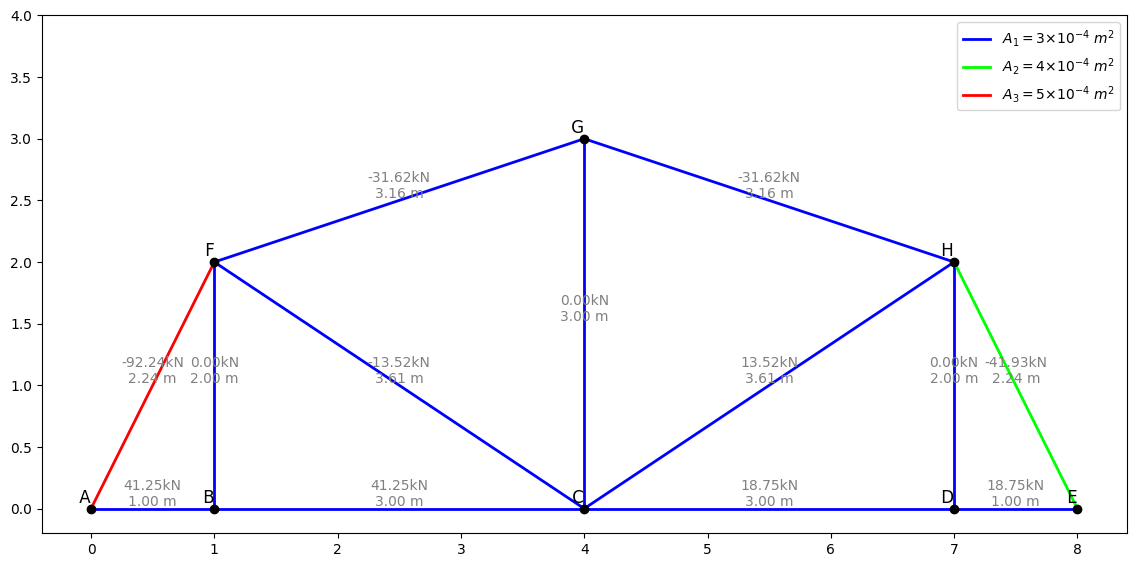

In [15]:
loading = [10, 80, 20, 20, 10]
lengths = get_all_lengths_list(get_lengths_from_genome(best_truss.fixed))
sections = best_truss.sections
forces = get_normal_forces(loading, lengths)

calculate_table(best_truss)
draw_truss(forces, lengths, sections)